In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import models, transforms, datasets
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path
import pandas as pd

#from google.colab.patches import cv2_imshow
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#transformations

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

In [4]:
#loading target train data

train_set = dsets.ImageFolder(root="Plant-Pathology-Domain-2/plantpathology/train", transform=transform_train)
print("Classes: ")
class_names=train_set.classes
print(class_names)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
print("Total Training Images:",len(train_loader))
print(train_set.class_to_idx)

Classes: 
['healthy', 'rust', 'scab']
Total Training Images: 194
{'healthy': 0, 'rust': 1, 'scab': 2}


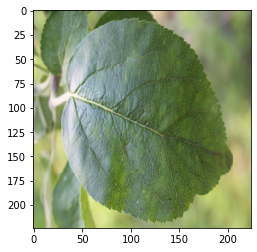

In [5]:
img , _ = next(iter(train_loader))
plt.imshow(img[5].permute(1, 2, 0))

In [6]:
#loading source train data

train_set1 = dsets.ImageFolder(root="Plant-Pathology-Domain-2/appleplantvillage/train", transform=transform_train)
print("Classes: ")
class_names=train_set.classes
print(class_names)
train_loader1 = torch.utils.data.DataLoader(train_set1, batch_size=8, shuffle=True)
print("Total Training Images:",len(train_loader1))
print(train_set.class_to_idx)

Classes: 
['healthy', 'rust', 'scab']
Total Training Images: 219
{'healthy': 0, 'rust': 1, 'scab': 2}


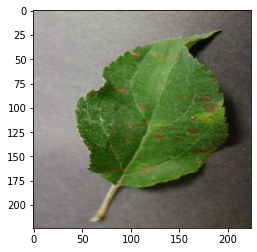

In [7]:
img , _ = next(iter(train_loader1))
plt.imshow(img[0].permute(1, 2, 0))

In [8]:
transform_test = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor()])  
test_set = dsets.ImageFolder("Plant-Pathology-Domain-2/plantpathology/test", transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True)
print("Total Test Images:",len(test_set))

Total Test Images: 175


In [9]:
test_set1 = dsets.ImageFolder("Plant-Pathology-Domain-2/appleplantvillage/test", transform=transform_test)
test_loader1 = torch.utils.data.DataLoader(test_set1, batch_size=128, shuffle=True)
print("Total Test Images:",len(test_set1))

Total Test Images: 384


In [61]:
vgg = CNNN()
vgg = vgg.to(device)

Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.0001)

In [1]:
vgg = SSNNN()
vgg = vgg.to(device)

Epochs = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.0001)

NameError: name 'SSNNN' is not defined

In [10]:
vgg = models.resnet50(pretrained=True)
vgg.fc = nn.Sequential(nn.Linear(2048, 3))
vgg = vgg.to(device)

Epochs = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.0001)

In [12]:
#vgg = models.resnet50(pretrained=True)
#vgg.fc = nn.Sequential(nn.Linear(2048, 3))



#optimizer = optim.SGD(vgg.parameters(), lr=0.01, momentum=0.9)

from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device

vgg.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        #print(inputs)
        print(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        #print(inputs)
        print(labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg(inputs)  #----> forward pass
        print(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(train_loader.dataset),
                100. * i / len(train_loader),
                loss.item()))
        
    correct = 0
    total = 0

    with torch.no_grad():
      for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the val images after epoch %d: %d %%' % (epoch ,100 * correct / total)) 



0it [00:00, ?it/s]

tensor([0, 0, 2, 2, 2, 0, 2, 0])
tensor([0, 0, 2, 2, 2, 0, 2, 0], device='cuda:0')
tensor([[-2.7082e-03,  2.3189e+00, -2.4005e+00],
        [ 2.3737e+00, -1.9500e+00, -1.3177e+00],
        [-2.4490e+00, -1.0955e-01,  2.8884e+00],
        [-4.5676e+00,  3.4742e+00,  1.3514e+00],
        [-1.9365e+00, -3.9568e-01,  2.0538e+00],
        [ 3.3208e+00, -1.4052e+00, -2.3073e+00],
        [-2.1511e+00,  1.5944e+00,  1.0207e+00],
        [ 2.2801e+00,  4.2635e-01, -3.2841e+00]], device='cuda:0',
       grad_fn=<AddmmBackward>)



Train Epoch: 0 [0/1552 (0%)]	Loss: 0.755825: : 0it [00:00, ?it/s]
Train Epoch: 0 [0/1552 (0%)]	Loss: 0.755825: : 1it [00:00,  1.61it/s]

tensor([1, 1, 0, 2, 0, 0, 2, 2])
tensor([1, 1, 0, 2, 0, 0, 2, 2], device='cuda:0')
tensor([[-3.1858,  5.8739, -1.7718],
        [-1.7322,  3.4249, -1.3982],
        [ 2.7269, -0.1648, -3.4046],
        [-2.6954, -0.3202,  2.7917],
        [ 1.1007, -2.1908,  0.6361],
        [ 3.2839, -0.9391, -2.8130],
        [-1.9922, -0.9644,  2.8656],
        [-0.0396, -1.5776,  1.3792]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [8/1552 (1%)]	Loss: 0.116446: : 1it [00:01,  1.61it/s]
Train Epoch: 0 [8/1552 (1%)]	Loss: 0.116446: : 2it [00:01,  1.61it/s]

tensor([0, 1, 1, 0, 1, 1, 2, 0])
tensor([0, 1, 1, 0, 1, 1, 2, 0], device='cuda:0')
tensor([[ 2.9773, -2.1861, -1.4807],
        [-0.4796,  2.2469, -1.7610],
        [-2.9528,  2.8151,  0.2443],
        [ 1.4780, -2.5917,  0.5126],
        [-3.0129,  4.0560, -0.3620],
        [-3.1683,  1.9193,  1.4909],
        [-0.1690, -2.2016,  2.0946],
        [ 2.6085, -0.3716, -2.8288]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [16/1552 (1%)]	Loss: 0.149015: : 2it [00:01,  1.61it/s]
Train Epoch: 0 [16/1552 (1%)]	Loss: 0.149015: : 3it [00:01,  1.60it/s]

tensor([2, 0, 1, 1, 1, 1, 1, 2])
tensor([2, 0, 1, 1, 1, 1, 1, 2], device='cuda:0')
tensor([[-0.0914, -2.1245,  1.7022],
        [ 3.6488, -1.9742, -2.2617],
        [ 0.7700,  0.0668, -1.4454],
        [-1.6632,  0.5427,  0.9286],
        [-1.3494,  2.3476, -0.8855],
        [-2.3542,  4.8295, -2.0050],
        [-1.5025,  2.3921, -0.8471],
        [-0.4771, -2.4482,  3.0409]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [24/1552 (2%)]	Loss: 0.307225: : 3it [00:02,  1.60it/s]
Train Epoch: 0 [24/1552 (2%)]	Loss: 0.307225: : 4it [00:02,  1.60it/s]

tensor([1, 2, 2, 1, 1, 0, 2, 2])
tensor([1, 2, 2, 1, 1, 0, 2, 2], device='cuda:0')
tensor([[-1.4294,  4.0995, -2.6073],
        [-1.1710, -1.3351,  2.1400],
        [-1.4316, -1.4904,  2.9303],
        [-1.3439,  3.4483, -1.9427],
        [-1.9400,  2.9109, -0.7712],
        [ 3.8580, -0.9535, -3.4707],
        [ 0.4361, -1.6723,  0.9210],
        [-0.1137, -1.6813,  1.3511]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [32/1552 (2%)]	Loss: 0.115039: : 4it [00:03,  1.60it/s]
Train Epoch: 0 [32/1552 (2%)]	Loss: 0.115039: : 5it [00:03,  1.60it/s]

tensor([1, 2, 0, 1, 1, 2, 0, 1])
tensor([1, 2, 0, 1, 1, 2, 0, 1], device='cuda:0')
tensor([[-2.7519,  4.7153, -1.0520],
        [-2.4863, -1.3961,  3.8828],
        [ 3.2553, -0.9584, -3.6882],
        [-1.9988,  1.1079,  1.0656],
        [-1.3801,  2.1391, -0.9593],
        [ 0.0670, -2.2605,  1.8073],
        [ 3.6196, -1.6407, -2.6987],
        [-1.6232,  2.2966, -0.1754]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [40/1552 (3%)]	Loss: 0.134408: : 5it [00:03,  1.60it/s]
Train Epoch: 0 [40/1552 (3%)]	Loss: 0.134408: : 6it [00:03,  1.60it/s]

tensor([0, 2, 1, 0, 0, 2, 0, 2])
tensor([0, 2, 1, 0, 0, 2, 0, 2], device='cuda:0')
tensor([[ 1.0584,  0.1222, -1.6342],
        [-5.2430,  1.6290,  3.9697],
        [-3.5069,  6.7143, -1.9924],
        [ 3.5113, -1.4746, -2.5518],
        [ 2.6682, -1.1736, -2.2770],
        [-2.0227, -0.4909,  2.2550],
        [ 0.5712, -0.3387, -0.3410],
        [ 0.3230, -1.4783,  0.6365]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [48/1552 (3%)]	Loss: 0.223640: : 6it [00:04,  1.60it/s]
Train Epoch: 0 [48/1552 (3%)]	Loss: 0.223640: : 7it [00:04,  1.60it/s]

tensor([0, 1, 1, 0, 1, 2, 0, 1])
tensor([0, 1, 1, 0, 1, 2, 0, 1], device='cuda:0')
tensor([[ 2.9297, -0.6281, -2.9496],
        [-0.6153,  2.2482, -1.1864],
        [-2.5661,  3.7428, -0.6782],
        [ 2.0672, -1.3488, -1.3079],
        [-0.8174,  1.9772, -1.0530],
        [-4.4907, -0.7166,  4.9036],
        [ 1.8579, -1.9913, -0.6662],
        [-1.2852,  0.2107,  1.1035]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [56/1552 (4%)]	Loss: 0.212284: : 7it [00:05,  1.60it/s]
Train Epoch: 0 [56/1552 (4%)]	Loss: 0.212284: : 8it [00:05,  1.60it/s]

tensor([1, 2, 1, 2, 1, 1, 0, 0])
tensor([1, 2, 1, 2, 1, 1, 0, 0], device='cuda:0')
tensor([[-0.2376,  3.1086, -2.6967],
        [-3.3229, -0.7102,  4.0180],
        [-2.0043,  2.9238, -0.4974],
        [-1.4944, -1.6908,  3.1705],
        [-0.5063,  1.2241, -0.9872],
        [-1.2584,  2.2052, -0.7403],
        [ 2.9312, -1.1388, -2.7490],
        [ 2.9776, -2.0342, -1.6071]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [64/1552 (4%)]	Loss: 0.059100: : 8it [00:05,  1.60it/s]
Train Epoch: 0 [64/1552 (4%)]	Loss: 0.059100: : 9it [00:05,  1.60it/s]

tensor([2, 2, 1, 2, 1, 2, 2, 1])
tensor([2, 2, 1, 2, 1, 2, 2, 1], device='cuda:0')
tensor([[-0.5105, -2.1153,  2.6286],
        [-0.8749, -1.6304,  2.1030],
        [-0.5496,  3.4310, -2.7547],
        [-3.5764, -0.4046,  3.9865],
        [ 0.0752,  3.2246, -3.0931],
        [ 2.1874, -2.0058, -0.9766],
        [-0.5861,  0.0383,  0.4771],
        [ 0.7833,  2.8444, -4.0345]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [72/1552 (5%)]	Loss: 0.528585: : 9it [00:06,  1.60it/s]
Train Epoch: 0 [72/1552 (5%)]	Loss: 0.528585: : 10it [00:06,  1.60it/s]

tensor([2, 2, 2, 2, 1, 1, 1, 0])
tensor([2, 2, 2, 2, 1, 1, 1, 0], device='cuda:0')
tensor([[-3.0096, -0.9229,  3.8385],
        [-0.2570, -1.4048,  1.1786],
        [-0.0102, -1.5186,  1.6687],
        [-3.0399, -0.3643,  3.2832],
        [ 1.2158,  1.0256, -2.1671],
        [-0.9008,  3.3414, -2.2474],
        [-2.1436,  4.5475, -1.6543],
        [ 4.5664, -0.9372, -5.0909]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [80/1552 (5%)]	Loss: 0.168940: : 10it [00:06,  1.60it/s]
Train Epoch: 0 [80/1552 (5%)]	Loss: 0.168940: : 11it [00:06,  1.59it/s]

tensor([1, 2, 2, 0, 2, 0, 0, 2])
tensor([1, 2, 2, 0, 2, 0, 0, 2], device='cuda:0')
tensor([[-1.3548,  6.0833, -4.7553],
        [-1.0223, -0.5826,  1.5459],
        [-4.3429,  0.7696,  3.6795],
        [ 2.9663, -1.3862, -2.4244],
        [-3.5426,  1.4704,  2.5408],
        [ 3.1068, -1.2766, -2.0562],
        [ 2.7910, -1.7574, -1.5174],
        [-1.9154,  0.2042,  1.5417]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [88/1552 (6%)]	Loss: 0.105753: : 11it [00:07,  1.59it/s]
Train Epoch: 0 [88/1552 (6%)]	Loss: 0.105753: : 12it [00:07,  1.59it/s]

tensor([2, 2, 2, 2, 1, 0, 1, 0])
tensor([2, 2, 2, 2, 1, 0, 1, 0], device='cuda:0')
tensor([[-2.9324, -0.9964,  3.9187],
        [-3.0708,  0.6413,  2.3199],
        [-2.3993, -0.3910,  2.7056],
        [-1.5898, -1.4430,  3.2219],
        [-1.4536,  4.5900, -2.5105],
        [ 4.0270, -1.3618, -3.3104],
        [-0.7338,  3.5378, -2.8072],
        [ 4.0175, -0.6515, -4.5066]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [96/1552 (6%)]	Loss: 0.035529: : 12it [00:08,  1.59it/s]
Train Epoch: 0 [96/1552 (6%)]	Loss: 0.035529: : 13it [00:08,  1.60it/s]

tensor([1, 1, 2, 2, 1, 2, 2, 2])
tensor([1, 1, 2, 2, 1, 2, 2, 2], device='cuda:0')
tensor([[-0.0520,  4.8173, -4.8327],
        [ 1.2713,  0.8883, -2.3472],
        [ 1.4924, -2.6589,  0.4302],
        [ 1.9611, -2.2888, -0.0515],
        [-0.2938,  3.3519, -2.9105],
        [-4.5835,  1.2891,  3.4315],
        [-0.7954, -1.3934,  2.1417],
        [-2.7198, -0.4522,  2.8527]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [104/1552 (7%)]	Loss: 0.588164: : 13it [00:08,  1.60it/s]
Train Epoch: 0 [104/1552 (7%)]	Loss: 0.588164: : 14it [00:08,  1.60it/s]

tensor([1, 0, 2, 0, 2, 0, 1, 0])
tensor([1, 0, 2, 0, 2, 0, 1, 0], device='cuda:0')
tensor([[-2.1145,  3.3442, -1.1026],
        [ 2.4459, -1.8775, -1.1851],
        [-6.5289,  2.9442,  4.1447],
        [ 1.4479, -1.4715, -0.1428],
        [-3.2499, -1.0490,  3.9866],
        [ 2.0163, -2.1760, -0.1699],
        [-0.5410,  4.5957, -3.7283],
        [ 2.7203, -0.4589, -3.1650]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [112/1552 (7%)]	Loss: 0.090503: : 14it [00:09,  1.60it/s]
Train Epoch: 0 [112/1552 (7%)]	Loss: 0.090503: : 15it [00:09,  1.59it/s]

tensor([1, 1, 1, 0, 2, 0, 1, 0])
tensor([1, 1, 1, 0, 2, 0, 1, 0], device='cuda:0')
tensor([[-1.3940,  2.8003, -1.6106],
        [-0.8603,  4.9756, -3.8472],
        [-1.6055,  0.5147,  1.0549],
        [ 2.3997, -1.8074, -1.5336],
        [-3.8474, -0.5693,  4.4197],
        [ 0.1504, -2.4810,  1.9489],
        [-1.4958,  3.0965, -1.3464],
        [ 2.5295, -2.3598, -0.2844]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [120/1552 (8%)]	Loss: 0.395287: : 15it [00:10,  1.59it/s]
Train Epoch: 0 [120/1552 (8%)]	Loss: 0.395287: : 16it [00:10,  1.59it/s]

tensor([1, 0, 1, 0, 2, 0, 1, 2])
tensor([1, 0, 1, 0, 2, 0, 1, 2], device='cuda:0')
tensor([[-1.2137,  1.9951, -0.2948],
        [ 2.4429, -2.1676, -0.8899],
        [-3.0571,  5.8897, -2.1206],
        [ 2.9396, -1.4347, -2.3611],
        [-0.7124, -1.7838,  2.3250],
        [ 1.0216, -2.2094,  0.4854],
        [-0.7902,  3.6414, -2.6823],
        [-4.3672, -0.4603,  4.5188]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [128/1552 (8%)]	Loss: 0.095399: : 16it [00:10,  1.59it/s]
Train Epoch: 0 [128/1552 (8%)]	Loss: 0.095399: : 17it [00:10,  1.59it/s]

tensor([2, 2, 1, 0, 1, 2, 1, 2])
tensor([2, 2, 1, 0, 1, 2, 1, 2], device='cuda:0')
tensor([[ 0.0778, -1.8326,  1.3288],
        [ 0.0681, -2.1791,  2.1592],
        [-1.6616,  5.3259, -3.4283],
        [ 1.8751, -1.6817, -0.5154],
        [ 2.4622, -0.3550, -3.1387],
        [-5.2584,  0.9263,  4.2411],
        [-0.5582,  4.4189, -3.6620],
        [-1.3680, -0.6353,  2.1341]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [136/1552 (9%)]	Loss: 0.442143: : 17it [00:11,  1.59it/s]
Train Epoch: 0 [136/1552 (9%)]	Loss: 0.442143: : 18it [00:11,  1.59it/s]

tensor([1, 2, 2, 1, 2, 0, 1, 0])
tensor([1, 2, 2, 1, 2, 0, 1, 0], device='cuda:0')
tensor([[ 0.7339,  1.7860, -2.6657],
        [-4.1033, -0.5758,  4.5212],
        [-1.4357, -1.3858,  2.7943],
        [-1.2860,  4.9767, -3.6563],
        [-2.6655, -0.9253,  3.8312],
        [ 2.8929, -1.8260, -1.9780],
        [-0.3891,  3.9619, -3.5012],
        [ 1.5869, -2.0573,  0.2000]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [144/1552 (9%)]	Loss: 0.078686: : 18it [00:11,  1.59it/s]
Train Epoch: 0 [144/1552 (9%)]	Loss: 0.078686: : 19it [00:11,  1.59it/s]

tensor([1, 2, 2, 0, 1, 1, 1, 0])
tensor([1, 2, 2, 0, 1, 1, 1, 0], device='cuda:0')
tensor([[-1.2039,  4.9480, -3.4792],
        [-4.3129, -0.8263,  5.4579],
        [-1.8933, -2.4440,  4.3162],
        [ 2.0673, -2.5673, -0.1074],
        [-1.4301,  1.8030, -0.2963],
        [-0.8422,  3.7832, -2.9595],
        [-0.8080,  0.7292, -0.3052],
        [ 3.0855, -0.9017, -3.1797]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [152/1552 (10%)]	Loss: 0.094548: : 19it [00:12,  1.59it/s]
Train Epoch: 0 [152/1552 (10%)]	Loss: 0.094548: : 20it [00:12,  1.60it/s]

tensor([2, 2, 2, 1, 0, 1, 1, 1])
tensor([2, 2, 2, 1, 0, 1, 1, 1], device='cuda:0')
tensor([[-2.6934, -1.5107,  4.1914],
        [-3.1956, -0.7354,  4.1643],
        [-0.5238, -2.4063,  2.6300],
        [-0.3756,  4.0286, -3.9725],
        [ 1.4908, -2.5196,  0.4593],
        [ 0.9434,  2.5158, -4.1337],
        [-1.4692,  1.9855, -0.1297],
        [ 0.5608,  3.1187, -3.7454]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [160/1552 (10%)]	Loss: 0.099751: : 20it [00:13,  1.60it/s]
Train Epoch: 0 [160/1552 (10%)]	Loss: 0.099751: : 21it [00:13,  1.60it/s]

tensor([2, 2, 2, 1, 1, 1, 1, 2])
tensor([2, 2, 2, 1, 1, 1, 1, 2], device='cuda:0')
tensor([[ 0.3994, -2.7393,  2.0973],
        [-4.0753, -0.8800,  4.8005],
        [ 1.4477, -2.4730,  0.4515],
        [ 0.0237,  4.4464, -4.7475],
        [-2.6046,  3.2722, -0.2820],
        [-0.7822,  2.0573, -1.3188],
        [ 0.0394,  3.5182, -4.0296],
        [ 0.0065, -2.5832,  2.5798]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [168/1552 (11%)]	Loss: 0.218056: : 21it [00:13,  1.60it/s]
Train Epoch: 0 [168/1552 (11%)]	Loss: 0.218056: : 22it [00:13,  1.60it/s]

tensor([2, 0, 2, 2, 2, 1, 1, 2])
tensor([2, 0, 2, 2, 2, 1, 1, 2], device='cuda:0')
tensor([[-2.9198,  0.4789,  2.4353],
        [ 2.6922, -0.8964, -2.5332],
        [-1.7176, -1.1180,  2.5320],
        [-0.2430, -1.0934,  1.0124],
        [-3.2476,  0.9681,  2.5144],
        [-0.4143,  6.9742, -6.6481],
        [ 0.7277,  0.2345, -0.9901],
        [-0.7054, -1.2221,  1.8036]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [176/1552 (11%)]	Loss: 0.242935: : 22it [00:14,  1.60it/s]
Train Epoch: 0 [176/1552 (11%)]	Loss: 0.242935: : 23it [00:14,  1.61it/s]

tensor([1, 0, 0, 0, 1, 1, 1, 1])
tensor([1, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
tensor([[-2.3670,  1.1718,  1.4355],
        [ 0.7669, -2.3398,  1.3618],
        [ 0.7914, -2.2869,  1.2872],
        [ 3.5166, -0.5280, -4.2104],
        [-1.8743,  4.0548, -1.8292],
        [-0.5760,  4.3221, -4.0033],
        [-2.9437,  0.7720,  2.2192],
        [-3.1344, -0.4002,  3.5483]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [184/1552 (12%)]	Loss: 1.068453: : 23it [00:15,  1.61it/s]
Train Epoch: 0 [184/1552 (12%)]	Loss: 1.068453: : 24it [00:15,  1.59it/s]

tensor([2, 0, 2, 1, 2, 1, 1, 1])
tensor([2, 0, 2, 1, 2, 1, 1, 1], device='cuda:0')
tensor([[-1.6211, -2.5906,  4.6484],
        [ 2.4987, -1.8404, -1.1337],
        [-3.1938, -1.9268,  4.9311],
        [-1.0160,  4.2198, -3.3309],
        [ 0.7149, -2.3866,  1.1631],
        [-2.1002,  3.9851, -1.6378],
        [-2.1554,  3.9714, -2.0886],
        [ 0.8135,  2.3066, -3.5982]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [192/1552 (12%)]	Loss: 0.096895: : 24it [00:15,  1.59it/s]
Train Epoch: 0 [192/1552 (12%)]	Loss: 0.096895: : 25it [00:15,  1.59it/s]

tensor([2, 2, 2, 2, 1, 0, 0, 0])
tensor([2, 2, 2, 2, 1, 0, 0, 0], device='cuda:0')
tensor([[-2.2231, -0.9894,  3.0676],
        [-3.9621, -0.2306,  4.4531],
        [-0.9286, -2.1209,  3.1223],
        [-2.6606,  2.1310,  0.7553],
        [-2.2982,  6.9310, -4.1619],
        [ 2.5326, -1.5834, -1.5639],
        [ 1.0978, -0.7071, -0.9135],
        [ 2.1462,  1.5067, -4.7851]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [200/1552 (13%)]	Loss: 0.297423: : 25it [00:16,  1.59it/s]
Train Epoch: 0 [200/1552 (13%)]	Loss: 0.297423: : 26it [00:16,  1.59it/s]

tensor([2, 1, 2, 0, 2, 1, 1, 0])
tensor([2, 1, 2, 0, 2, 1, 1, 0], device='cuda:0')
tensor([[-0.1354, -2.6138,  2.9184],
        [-1.3313,  4.4167, -3.0279],
        [-3.5416, -0.7686,  4.1208],
        [ 1.4467, -1.9617, -0.2735],
        [-2.4023, -1.3250,  3.6720],
        [-2.2727,  5.2658, -2.6695],
        [-1.1899,  5.4365, -4.1604],
        [ 2.5486, -2.3216, -1.1894]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [208/1552 (13%)]	Loss: 0.037033: : 26it [00:16,  1.59it/s]
Train Epoch: 0 [208/1552 (13%)]	Loss: 0.037033: : 27it [00:16,  1.59it/s]

tensor([1, 2, 0, 2, 1, 0, 2, 0])
tensor([1, 2, 0, 2, 1, 0, 2, 0], device='cuda:0')
tensor([[-2.0237,  3.3340, -1.3005],
        [-5.6539,  0.3675,  5.3753],
        [ 0.7975, -1.1525, -0.0150],
        [-1.1929, -1.9791,  3.2873],
        [-2.0424,  5.5874, -2.8915],
        [ 1.5094, -1.4662, -0.3442],
        [ 0.6168, -0.4818, -0.5892],
        [ 2.2019,  0.6834, -4.0858]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [216/1552 (14%)]	Loss: 0.322982: : 27it [00:17,  1.59it/s]
Train Epoch: 0 [216/1552 (14%)]	Loss: 0.322982: : 28it [00:17,  1.59it/s]

tensor([2, 1, 2, 1, 1, 0, 1, 0])
tensor([2, 1, 2, 1, 1, 0, 1, 0], device='cuda:0')
tensor([[-2.2216, -2.1842,  4.2614],
        [-1.2146,  1.8663, -0.8163],
        [-2.2545, -2.1214,  4.4181],
        [-0.9870,  3.4198, -2.4863],
        [-2.1257,  2.7823, -0.3930],
        [ 2.4457, -2.5461, -0.3815],
        [-3.5083,  6.6877, -2.6319],
        [ 3.2116, -1.3885, -3.0841]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [224/1552 (14%)]	Loss: 0.031587: : 28it [00:18,  1.59it/s]
Train Epoch: 0 [224/1552 (14%)]	Loss: 0.031587: : 29it [00:18,  1.59it/s]

tensor([2, 1, 0, 0, 2, 0, 0, 1])
tensor([2, 1, 0, 0, 2, 0, 0, 1], device='cuda:0')
tensor([[-4.3707, -0.4996,  5.0975],
        [-1.1445,  5.1408, -4.0714],
        [ 2.0906, -1.3060, -1.7911],
        [ 0.8599, -1.6927,  0.7092],
        [-2.3299, -1.2896,  3.6655],
        [ 0.8008, -1.4592,  0.1709],
        [ 1.5977, -1.6150, -0.7550],
        [-3.9344,  8.1257, -3.4488]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [232/1552 (15%)]	Loss: 0.168679: : 29it [00:18,  1.59it/s]
Train Epoch: 0 [232/1552 (15%)]	Loss: 0.168679: : 30it [00:18,  1.58it/s]

tensor([1, 0, 2, 1, 0, 1, 1, 1])
tensor([1, 0, 2, 1, 0, 1, 1, 1], device='cuda:0')
tensor([[-1.6096,  2.4024, -0.9061],
        [ 2.3364, -2.3888, -0.3921],
        [-3.3545, -1.9755,  5.3559],
        [-1.9592,  3.3177, -1.0838],
        [ 2.0996, -1.8888, -0.8857],
        [-1.0682,  1.4982, -0.6487],
        [-1.0042,  1.7162, -0.8263],
        [-2.0135,  3.6939, -1.8456]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [240/1552 (15%)]	Loss: 0.066103: : 30it [00:19,  1.58it/s]
Train Epoch: 0 [240/1552 (15%)]	Loss: 0.066103: : 31it [00:19,  1.59it/s]

tensor([1, 0, 1, 2, 1, 2, 0, 1])
tensor([1, 0, 1, 2, 1, 2, 0, 1], device='cuda:0')
tensor([[-4.4333,  5.7568, -0.7096],
        [ 2.2472, -2.6020, -0.2281],
        [-0.1930,  2.0820, -2.4523],
        [-0.8725, -2.4178,  3.2791],
        [-1.3645,  3.4167, -2.2966],
        [-3.1232, -1.4911,  4.6336],
        [ 2.2367, -2.1877, -0.4982],
        [-1.0947,  3.5998, -2.5948]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [248/1552 (16%)]	Loss: 0.039432: : 31it [00:20,  1.59it/s]
Train Epoch: 0 [248/1552 (16%)]	Loss: 0.039432: : 32it [00:20,  1.59it/s]

tensor([1, 1, 0, 2, 1, 0, 2, 1])
tensor([1, 1, 0, 2, 1, 0, 2, 1], device='cuda:0')
tensor([[-1.6638,  3.3575, -2.2144],
        [-0.2709,  1.6836, -1.4553],
        [ 3.1229, -1.6320, -2.2162],
        [-3.0405, -1.9081,  4.7531],
        [-3.5970,  4.2307,  0.0735],
        [ 2.2658, -2.5083, -0.3732],
        [-1.8671, -2.0974,  3.8873],
        [-1.3820,  5.2565, -3.8655]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [256/1552 (16%)]	Loss: 0.036865: : 32it [00:20,  1.59it/s]
Train Epoch: 0 [256/1552 (16%)]	Loss: 0.036865: : 33it [00:20,  1.59it/s]

tensor([1, 1, 0, 2, 1, 1, 1, 1])
tensor([1, 1, 0, 2, 1, 1, 1, 1], device='cuda:0')
tensor([[-1.0634,  1.1688, -0.5086],
        [-1.2908,  3.4314, -2.2056],
        [ 2.5984, -3.4770,  0.0721],
        [-0.2498, -3.2900,  3.4752],
        [-1.5132,  1.4242,  0.0166],
        [-2.1156,  3.4630, -1.1971],
        [-1.1452,  2.8685, -1.8794],
        [-2.1261,  1.3678,  0.7760]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [264/1552 (17%)]	Loss: 0.141772: : 33it [00:21,  1.59it/s]
Train Epoch: 0 [264/1552 (17%)]	Loss: 0.141772: : 34it [00:21,  1.59it/s]

tensor([2, 2, 2, 0, 2, 2, 1, 0])
tensor([2, 2, 2, 0, 2, 2, 1, 0], device='cuda:0')
tensor([[-0.6846, -1.4116,  2.0810],
        [-3.6966,  0.1900,  3.6614],
        [-1.2420, -1.4165,  2.4655],
        [ 2.8389, -0.2610, -3.5980],
        [-0.7023, -1.0930,  1.5438],
        [-2.0064,  0.1356,  2.0693],
        [-3.5943,  9.5624, -5.5227],
        [ 2.5758, -0.3068, -2.9417]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [272/1552 (18%)]	Loss: 0.072701: : 34it [00:21,  1.59it/s]
Train Epoch: 0 [272/1552 (18%)]	Loss: 0.072701: : 35it [00:21,  1.59it/s]

tensor([2, 0, 0, 1, 1, 2, 2, 2])
tensor([2, 0, 0, 1, 1, 2, 2, 2], device='cuda:0')
tensor([[-2.1156, -1.0600,  3.1665],
        [ 2.0062, -0.6247, -2.1344],
        [ 1.7376, -1.5621, -0.7560],
        [-2.7130,  7.2401, -3.9653],
        [-1.1489,  5.8952, -4.8359],
        [-2.9340, -1.1913,  4.2314],
        [-2.2446, -0.9748,  3.1614],
        [ 0.8345, -1.7106,  0.2032]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [280/1552 (18%)]	Loss: 0.168846: : 35it [00:22,  1.59it/s]
Train Epoch: 0 [280/1552 (18%)]	Loss: 0.168846: : 36it [00:22,  1.59it/s]

tensor([1, 0, 0, 1, 1, 1, 1, 0])
tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
tensor([[-3.0040,  4.0419, -0.8044],
        [ 2.2038, -2.9412,  0.1042],
        [ 1.9450, -2.2273, -0.2276],
        [-1.3404,  2.7359, -1.4195],
        [-4.2914,  1.8139,  2.7705],
        [-0.7745,  3.1214, -2.5102],
        [-3.5137,  2.8946,  1.1806],
        [ 2.4994, -2.5504, -0.9818]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [288/1552 (19%)]	Loss: 0.224077: : 36it [00:23,  1.59it/s]
Train Epoch: 0 [288/1552 (19%)]	Loss: 0.224077: : 37it [00:23,  1.59it/s]

tensor([1, 0, 0, 2, 0, 1, 0, 1])
tensor([1, 0, 0, 2, 0, 1, 0, 1], device='cuda:0')
tensor([[-3.3665,  5.0978, -1.2631],
        [ 1.5936, -0.4451, -1.9236],
        [ 0.9085, -1.0245, -0.5357],
        [-2.7444, -1.2217,  3.9049],
        [ 0.3769, -2.0804,  1.3780],
        [-3.6204,  3.6490,  0.6966],
        [ 1.6958, -1.0583, -1.3347],
        [-1.2660,  3.7284, -2.4900]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [296/1552 (19%)]	Loss: 0.247903: : 37it [00:23,  1.59it/s]
Train Epoch: 0 [296/1552 (19%)]	Loss: 0.247903: : 38it [00:23,  1.59it/s]

tensor([2, 2, 2, 0, 0, 2, 0, 1])
tensor([2, 2, 2, 0, 0, 2, 0, 1], device='cuda:0')
tensor([[-3.7009,  0.2041,  3.5080],
        [-3.0837,  0.5649,  2.4016],
        [-2.7416,  0.3095,  2.5605],
        [ 2.5910, -1.0494, -2.0807],
        [ 2.4665, -0.3849, -2.7546],
        [-1.4074, -1.1855,  2.5096],
        [ 2.4064, -0.6392, -2.5351],
        [-3.1393,  8.8373, -5.0328]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [304/1552 (20%)]	Loss: 0.060764: : 38it [00:24,  1.59it/s]
Train Epoch: 0 [304/1552 (20%)]	Loss: 0.060764: : 39it [00:24,  1.60it/s]

tensor([0, 1, 1, 1, 0, 2, 2, 2])
tensor([0, 1, 1, 1, 0, 2, 2, 2], device='cuda:0')
tensor([[ 2.4413, -1.9045, -1.3798],
        [-1.7957,  5.0583, -3.3279],
        [-2.3429,  3.9399, -1.4704],
        [-2.2031,  5.7463, -3.4142],
        [ 3.5664, -2.2225, -2.0830],
        [-1.4950, -0.8489,  2.0622],
        [-2.1589, -1.4011,  3.6782],
        [-2.9205, -1.6011,  4.5670]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [312/1552 (20%)]	Loss: 0.017539: : 39it [00:25,  1.60it/s]
Train Epoch: 0 [312/1552 (20%)]	Loss: 0.017539: : 40it [00:25,  1.60it/s]

tensor([0, 2, 2, 2, 0, 1, 0, 0])
tensor([0, 2, 2, 2, 0, 1, 0, 0], device='cuda:0')
tensor([[-0.2531,  0.3334, -0.4479],
        [-3.5954, -0.1587,  3.8116],
        [ 0.1632, -0.7987,  0.5143],
        [-2.1011, -1.2992,  3.3806],
        [ 1.6874,  0.2702, -3.0951],
        [-4.2867,  7.9637, -2.8955],
        [ 1.4137,  0.5076, -2.2373],
        [ 1.4181, -0.9931, -0.8250]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [320/1552 (21%)]	Loss: 0.344902: : 40it [00:25,  1.60it/s]
Train Epoch: 0 [320/1552 (21%)]	Loss: 0.344902: : 41it [00:25,  1.60it/s]

tensor([1, 2, 0, 0, 1, 2, 2, 1])
tensor([1, 2, 0, 0, 1, 2, 2, 1], device='cuda:0')
tensor([[-3.7499,  4.3524, -0.2573],
        [-2.3921, -0.9327,  3.1054],
        [ 3.5334, -0.9282, -3.6180],
        [ 1.8477, -1.8882, -0.2666],
        [-1.5996,  5.2849, -4.0262],
        [-0.7423, -2.2781,  2.9147],
        [-1.2415, -1.6187,  3.0845],
        [-2.0153,  4.4948, -2.4499]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [328/1552 (21%)]	Loss: 0.029434: : 41it [00:26,  1.60it/s]
Train Epoch: 0 [328/1552 (21%)]	Loss: 0.029434: : 42it [00:26,  1.60it/s]

tensor([2, 0, 1, 2, 2, 2, 1, 0])
tensor([2, 0, 1, 2, 2, 2, 1, 0], device='cuda:0')
tensor([[-2.6364, -0.9310,  3.2977],
        [ 4.1257, -1.7492, -3.0075],
        [-3.8687,  9.1517, -4.6050],
        [-2.6942, -0.6215,  3.3250],
        [-2.2219, -0.0975,  2.4001],
        [-1.5489, -0.3023,  1.8641],
        [ 0.0350,  1.4774, -2.3094],
        [ 2.5790, -1.0692, -2.1975]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [336/1552 (22%)]	Loss: 0.066517: : 42it [00:26,  1.60it/s]
Train Epoch: 0 [336/1552 (22%)]	Loss: 0.066517: : 43it [00:26,  1.60it/s]

tensor([0, 0, 0, 0, 2, 0, 0, 1])
tensor([0, 0, 0, 0, 2, 0, 0, 1], device='cuda:0')
tensor([[ 1.1076e+00, -1.0153e+00, -5.5752e-01],
        [ 2.2948e+00, -8.5263e-01, -2.0564e+00],
        [-1.1150e+00, -1.2004e+00,  2.2316e+00],
        [-1.4176e+00,  8.2647e-01,  4.3179e-03],
        [-2.0868e+00, -2.2427e+00,  4.4650e+00],
        [ 1.2027e+00, -1.1031e-01, -1.6313e+00],
        [ 2.6577e+00, -5.1348e-01, -2.6771e+00],
        [-7.8339e+00,  1.1391e+01, -2.3382e+00]], device='cuda:0',
       grad_fn=<AddmmBackward>)



Train Epoch: 0 [344/1552 (22%)]	Loss: 0.843351: : 43it [00:27,  1.60it/s]
Train Epoch: 0 [344/1552 (22%)]	Loss: 0.843351: : 44it [00:27,  1.59it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0])
tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
tensor([[ 1.4445, -0.9246, -0.8864],
        [-0.8550, -1.5303,  1.9780],
        [ 1.8584, -1.3633, -0.8879],
        [-6.0173,  7.8980, -1.1144],
        [-4.3316,  3.6023,  0.8301],
        [-0.0164, -0.6278,  0.2014],
        [ 2.2568, -1.1636, -1.5774],
        [ 1.5041, -0.5844, -1.4139]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [352/1552 (23%)]	Loss: 0.561737: : 44it [00:28,  1.59it/s]
Train Epoch: 0 [352/1552 (23%)]	Loss: 0.561737: : 45it [00:28,  1.59it/s]

tensor([1, 1, 1, 1, 0, 1, 2, 0])
tensor([1, 1, 1, 1, 0, 1, 2, 0], device='cuda:0')
tensor([[-1.9151,  5.0775, -2.9195],
        [-0.9784, -0.6281,  1.0242],
        [-3.5698,  4.8897, -0.7631],
        [-2.8032,  4.1569, -1.2044],
        [ 2.3187, -2.6838, -0.6298],
        [-2.6722,  2.0019,  0.6330],
        [-0.1843, -3.0354,  3.1346],
        [ 4.4219, -2.7293, -2.4366]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [360/1552 (23%)]	Loss: 0.284557: : 45it [00:28,  1.59it/s]
Train Epoch: 0 [360/1552 (23%)]	Loss: 0.284557: : 46it [00:28,  1.59it/s]

tensor([2, 1, 1, 1, 1, 1, 0, 1])
tensor([2, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
tensor([[-1.9324, -3.3649,  5.4043],
        [ 0.1278,  0.9139, -1.3496],
        [-2.2462,  3.6000, -1.2290],
        [-0.2123,  2.2924, -2.1005],
        [-2.2750,  3.6605, -1.2320],
        [ 0.0783, -0.3822, -0.3736],
        [ 3.8261, -2.7008, -1.6630],
        [-2.4018,  3.2453, -1.0341]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [368/1552 (24%)]	Loss: 0.232248: : 46it [00:29,  1.59it/s]
Train Epoch: 0 [368/1552 (24%)]	Loss: 0.232248: : 47it [00:29,  1.59it/s]

tensor([2, 0, 0, 2, 0, 2, 2, 1])
tensor([2, 0, 0, 2, 0, 2, 2, 1], device='cuda:0')
tensor([[-3.6354,  0.5174,  3.1065],
        [ 2.4687, -0.1155, -2.9960],
        [ 3.9001, -2.0059, -2.5066],
        [-0.1729,  0.6145, -0.7031],
        [ 1.8272,  0.3891, -2.5079],
        [-2.0204, -0.9933,  2.7261],
        [-0.3753, -1.8558,  1.9340],
        [-5.9012,  8.8328, -2.0941]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [376/1552 (24%)]	Loss: 0.298382: : 47it [00:30,  1.59it/s]
Train Epoch: 0 [376/1552 (24%)]	Loss: 0.298382: : 48it [00:30,  1.59it/s]

tensor([2, 1, 2, 1, 0, 1, 2, 2])
tensor([2, 1, 2, 1, 0, 1, 2, 2], device='cuda:0')
tensor([[-1.3588, -1.4767,  2.9264],
        [-0.4948,  3.7573, -3.2878],
        [ 2.2986, -1.0770, -2.1156],
        [-3.0975,  3.5713, -0.4220],
        [ 3.9906, -2.2705, -2.5986],
        [-4.6651,  7.5514, -2.0744],
        [-1.0586, -1.6097,  2.3663],
        [ 0.6539, -2.4567,  1.4337]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [384/1552 (25%)]	Loss: 0.620544: : 48it [00:30,  1.59it/s]
Train Epoch: 0 [384/1552 (25%)]	Loss: 0.620544: : 49it [00:30,  1.59it/s]

tensor([0, 0, 0, 1, 2, 0, 1, 0])
tensor([0, 0, 0, 1, 2, 0, 1, 0], device='cuda:0')
tensor([[ 2.2298, -1.3793, -1.5723],
        [ 1.1327, -2.5948,  0.8058],
        [ 1.5383, -1.8164, -0.3604],
        [-3.7948,  5.2651, -0.7286],
        [-0.2497, -1.5731,  1.8095],
        [ 2.8936, -1.2343, -2.1746],
        [-8.1204,  9.6525, -0.5825],
        [ 1.7917, -0.9194, -1.3694]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [392/1552 (25%)]	Loss: 0.131553: : 49it [00:31,  1.59it/s]
Train Epoch: 0 [392/1552 (25%)]	Loss: 0.131553: : 50it [00:31,  1.59it/s]

tensor([1, 0, 2, 1, 0, 1, 2, 2])
tensor([1, 0, 2, 1, 0, 1, 2, 2], device='cuda:0')
tensor([[-0.1936,  2.7810, -2.9466],
        [ 3.0792, -1.6660, -2.1586],
        [-0.5977, -2.3193,  2.5960],
        [-5.2945,  7.6001, -1.4365],
        [ 2.0446, -1.8005, -0.9340],
        [-0.0794,  2.8877, -2.8197],
        [-0.3021, -1.8394,  1.9337],
        [-1.4588, -0.9581,  2.3073]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [400/1552 (26%)]	Loss: 0.052358: : 50it [00:32,  1.59it/s]
Train Epoch: 0 [400/1552 (26%)]	Loss: 0.052358: : 51it [00:32,  1.59it/s]

tensor([1, 0, 1, 0, 1, 2, 1, 1])
tensor([1, 0, 1, 0, 1, 2, 1, 1], device='cuda:0')
tensor([[-2.2477,  4.0359, -1.8330],
        [ 2.8394, -2.0380, -1.7582],
        [-2.5646,  1.5244,  1.1476],
        [ 4.5324, -3.1614, -2.1244],
        [-2.6891,  3.7847, -0.8193],
        [-0.8429, -2.9885,  3.7425],
        [-1.8240,  2.3955, -0.5720],
        [-1.0445,  3.1146, -1.9034]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [408/1552 (26%)]	Loss: 0.083138: : 51it [00:32,  1.59it/s]
Train Epoch: 0 [408/1552 (26%)]	Loss: 0.083138: : 52it [00:32,  1.60it/s]

tensor([2, 1, 2, 1, 2, 1, 1, 0])
tensor([2, 1, 2, 1, 2, 1, 1, 0], device='cuda:0')
tensor([[-0.6389, -2.4074,  2.5970],
        [-1.5072,  4.2522, -2.5645],
        [ 0.9061, -3.1783,  2.3260],
        [-3.7994,  4.9932, -0.9867],
        [-0.2782, -1.1714,  1.2780],
        [-0.8602,  2.4495, -1.8563],
        [-1.7936,  3.1508, -1.3882],
        [ 4.7095, -2.2625, -3.2885]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [416/1552 (27%)]	Loss: 0.074962: : 52it [00:33,  1.60it/s]
Train Epoch: 0 [416/1552 (27%)]	Loss: 0.074962: : 53it [00:33,  1.61it/s]

tensor([2, 1, 2, 0, 0, 1, 0, 0])
tensor([2, 1, 2, 0, 0, 1, 0, 0], device='cuda:0')
tensor([[-0.0400, -1.9192,  1.9121],
        [-4.6172,  6.5804, -1.4437],
        [-1.5046, -1.4734,  2.8766],
        [ 2.4997, -1.6333, -1.4204],
        [ 2.9324, -1.3062, -2.3366],
        [-5.9167,  7.8503, -1.1214],
        [ 2.0403, -1.5657, -1.0959],
        [ 2.0465, -1.4937, -1.2670]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [424/1552 (27%)]	Loss: 0.045418: : 53it [00:33,  1.61it/s]
Train Epoch: 0 [424/1552 (27%)]	Loss: 0.045418: : 54it [00:33,  1.60it/s]

tensor([2, 2, 0, 0, 2, 1, 1, 0])
tensor([2, 2, 0, 0, 2, 1, 1, 0], device='cuda:0')
tensor([[-1.3449, -0.0818,  1.1181],
        [-0.3985, -2.6351,  2.9545],
        [ 3.2297, -0.9703, -2.9075],
        [ 2.4301, -1.5534, -1.4555],
        [-0.7018, -1.0959,  1.5641],
        [-1.9509,  4.9928, -2.7583],
        [-6.6615,  7.9205, -0.6177],
        [ 3.0074, -1.7811, -1.7606]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [432/1552 (28%)]	Loss: 0.074815: : 54it [00:34,  1.60it/s]
Train Epoch: 0 [432/1552 (28%)]	Loss: 0.074815: : 55it [00:34,  1.60it/s]

tensor([1, 2, 1, 0, 0, 2, 2, 1])
tensor([1, 2, 1, 0, 0, 2, 2, 1], device='cuda:0')
tensor([[-2.0858e+00,  4.3679e+00, -2.3428e+00],
        [ 7.0466e-03, -2.5321e+00,  2.1881e+00],
        [-2.7559e+00,  5.4610e+00, -2.6547e+00],
        [ 2.6906e+00, -1.9143e+00, -1.5282e+00],
        [ 3.5075e+00, -2.4733e+00, -1.9086e+00],
        [ 1.0168e+00, -2.5642e+00,  1.2834e+00],
        [ 6.0609e-01, -2.4985e+00,  1.5571e+00],
        [-6.5382e+00,  8.6226e+00, -9.0973e-01]], device='cuda:0',
       grad_fn=<AddmmBackward>)



Train Epoch: 0 [440/1552 (28%)]	Loss: 0.133695: : 55it [00:35,  1.60it/s]
Train Epoch: 0 [440/1552 (28%)]	Loss: 0.133695: : 56it [00:35,  1.58it/s]

tensor([0, 2, 2, 2, 2, 0, 1, 0])
tensor([0, 2, 2, 2, 2, 0, 1, 0], device='cuda:0')
tensor([[ 2.9634, -0.6050, -2.7963],
        [-0.2446,  0.4607, -0.4990],
        [ 0.2178, -1.7547,  1.5475],
        [-1.9261, -0.6778,  2.4155],
        [-3.9077,  1.4193,  2.6926],
        [ 2.6082, -1.4054, -1.8626],
        [-6.0460,  9.9761, -3.0676],
        [ 3.5070, -2.5171, -2.1137]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [448/1552 (29%)]	Loss: 0.277921: : 56it [00:35,  1.58it/s]
Train Epoch: 0 [448/1552 (29%)]	Loss: 0.277921: : 57it [00:35,  1.57it/s]

tensor([2, 2, 1, 2, 0, 0, 1, 1])
tensor([2, 2, 1, 2, 0, 0, 1, 1], device='cuda:0')
tensor([[ 1.1744, -1.5962, -0.2491],
        [-0.8865, -2.3622,  3.0819],
        [-2.1254,  4.1076, -1.9420],
        [-0.9938, -1.6868,  2.1850],
        [ 2.9479, -1.6855, -2.0038],
        [ 3.1872, -2.4352, -0.8938],
        [-5.9125,  8.0611, -1.1007],
        [ 0.1156,  2.6811, -3.1465]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [456/1552 (29%)]	Loss: 0.236283: : 57it [00:36,  1.57it/s]
Train Epoch: 0 [456/1552 (29%)]	Loss: 0.236283: : 58it [00:36,  1.57it/s]

tensor([1, 0, 2, 0, 0, 2, 0, 2])
tensor([1, 0, 2, 0, 0, 2, 0, 2], device='cuda:0')
tensor([[-7.1200, 11.9384, -3.1241],
        [ 3.2398, -1.4617, -2.9413],
        [-0.2906, -0.8801,  1.0060],
        [ 3.3805, -1.4817, -2.2427],
        [ 2.4713, -1.7625, -1.6775],
        [-2.2779,  0.2619,  1.6328],
        [ 1.2560, -0.7705, -0.7504],
        [-3.1757, -1.5593,  4.6604]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [464/1552 (30%)]	Loss: 0.110877: : 58it [00:37,  1.57it/s]
Train Epoch: 0 [464/1552 (30%)]	Loss: 0.110877: : 59it [00:37,  1.58it/s]

tensor([2, 0, 0, 1, 2, 2, 0, 0])
tensor([2, 0, 0, 1, 2, 2, 0, 0], device='cuda:0')
tensor([[-2.0796, -0.4152,  2.1956],
        [ 2.0182, -1.1744, -1.1978],
        [ 2.5083, -0.8733, -2.0463],
        [-5.3352,  8.7287, -2.5958],
        [-2.5974, -1.3442,  4.0763],
        [-1.7246,  0.4596,  1.5133],
        [ 2.3402, -1.2058, -2.3324],
        [ 2.9690, -0.8754, -2.8168]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [472/1552 (30%)]	Loss: 0.075064: : 59it [00:37,  1.58it/s]
Train Epoch: 0 [472/1552 (30%)]	Loss: 0.075064: : 60it [00:37,  1.57it/s]

tensor([1, 1, 0, 2, 0, 1, 2, 0])
tensor([1, 1, 0, 2, 0, 1, 2, 0], device='cuda:0')
tensor([[-1.5317,  2.7168, -1.4224],
        [-3.0654,  6.0031, -2.9407],
        [ 2.9367, -1.7270, -1.5758],
        [-0.8081, -2.7061,  3.3489],
        [ 4.3572, -3.1470, -1.8041],
        [-5.1093,  7.9608, -1.6424],
        [-1.4968, -2.4060,  3.5343],
        [ 0.9781, -0.7369, -1.1245]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [480/1552 (31%)]	Loss: 0.042986: : 60it [00:38,  1.57it/s]
Train Epoch: 0 [480/1552 (31%)]	Loss: 0.042986: : 61it [00:38,  1.58it/s]

tensor([1, 2, 2, 2, 0, 1, 2, 1])
tensor([1, 2, 2, 2, 0, 1, 2, 1], device='cuda:0')
tensor([[-0.6318,  3.8863, -3.5457],
        [-0.8846, -2.0970,  3.0183],
        [-0.0982, -2.1508,  1.9865],
        [-0.0741, -2.7715,  2.7651],
        [ 4.0422, -2.5231, -2.4938],
        [-3.1464,  6.3818, -2.9466],
        [-1.3292, -0.7419,  1.7669],
        [-1.7888,  5.5987, -3.5282]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [488/1552 (31%)]	Loss: 0.044009: : 61it [00:38,  1.58it/s]
Train Epoch: 0 [488/1552 (31%)]	Loss: 0.044009: : 62it [00:38,  1.59it/s]

tensor([1, 1, 1, 2, 1, 0, 2, 2])
tensor([1, 1, 1, 2, 1, 0, 2, 2], device='cuda:0')
tensor([[-0.2061,  3.0682, -2.8570],
        [-0.1711,  2.4823, -2.9346],
        [-3.7602,  6.5398, -2.4361],
        [ 0.5942, -3.5074,  2.4529],
        [-2.5725,  4.5751, -1.4346],
        [ 4.4044, -3.4150, -1.8424],
        [-1.6396, -1.2601,  2.5681],
        [-1.0328, -2.2400,  3.1204]], device='cuda:0', grad_fn=<AddmmBackward>)



Train Epoch: 0 [496/1552 (32%)]	Loss: 0.040114: : 62it [00:39,  1.59it/s]
Train Epoch: 0 [496/1552 (32%)]	Loss: 0.040114: : 63it [00:39,  1.59it/s]

KeyboardInterrupt: 

In [217]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = vgg(images)
    #print(outputs.data)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the val images: %d %%' % (100 * correct / total))

Accuracy of the network on the val images: 81 %


In [218]:
modules=list(vgg.children())[:-1]
vgg=nn.Sequential(*modules)
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
from torch.autograd import Function

# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None

In [ ]:
class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50), nn.Dropout2d(), nn.MaxPool2d(2),
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 53 * 53, 100), nn.BatchNorm1d(100), nn.Dropout2d(),
            nn.ReLU(True),
            nn.Linear(100, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 3),
            nn.LogSoftmax(dim=1),
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 53 * 53, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1),
            
        )

    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, 224, 224)
        #print(x.data.shape)
        #print(x.shape)
        #print("1")
        
        features = self.feature_extractor(x)
        #print(features.shape)
        #print("2")

        features = features.view(-1, 50 * 53 * 53)
        #features = features.view(x.size(0),-1)
        #print(features.shape)
        #print("3")

        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        #print(reverse_features.shape)
        #print("4")

       
        class_pred = self.class_classifier(features)
        #print(class_pred.shape)
        #print("5")


        domain_pred = self.domain_classifier(reverse_features)
        #print(domain_pred.shape)
        return class_pred, domain_pred

In [ ]:
model = DACNN()

x0_s, y0_s = next(iter(train_loader))
x0_t, y0_t = next(iter(train_loader1))

print('source domain: ', x0_s.shape, y0_s.shape)
print('target domain: ', x0_t.shape, y0_t.shape)

model(x0_s)
model(x0_t)

In [ ]:
n_epochs = 1
lr = 1e-3

# Setup optimizer as usual
model = DACNN()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

In [ ]:
max_batches = min(len(train_loader), len(train_loader1))
max_batches

In [57]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device

model.train()

for epoch_idx in range(n_epochs):  # loop over the dataset multiple times
    i=0
    for data1, data2 in tqdm(zip(train_loader,train_loader1),total=max_batches):
      optimizer.zero_grad()
      p = float(i + epoch_idx * max_batches) / (n_epochs * max_batches)
      grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1



      inputs, labels = data2
      inputs, labels = inputs.to(device), labels.to(device)
      y_s_domain = torch.zeros(len(inputs), dtype=torch.long).to(device) # generate source domain labels

      inputst, labelst = data1
      inputst, labelst = inputst.to(device), labelst.to(device)
      y_t_domain = torch.zeros(len(inputst), dtype=torch.long).to(device) # generate source domain labels

      class_pred, domain_pred = model(inputs, grl_lambda)
     # print(len(class_pred))
     # print(len(domain_pred))
      #print("break")

      loss_s_label = loss_fn_class(class_pred, labels)
      loss_s_domain = loss_fn_domain(domain_pred, y_s_domain)

      _, domain_pred = model(inputst, grl_lambda)
      loss_t_domain = loss_fn_domain(domain_pred, y_t_domain)
      loss = loss_t_domain + loss_s_domain + loss_s_label
      loss.backward()
      optimizer.step()
      i=i+1
      print(f'[{i}/{max_batches}] '
            f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
            f't_domain_loss: {loss_t_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
            )
      correct = 0
      total = 0

      # with torch.no_grad():
      #   for data in test_loader1:
      #     images, labels = data
      #     images, labels = images.to(device), labels.to(device)
      #     outputs = model(images)
      #     #print(outputs[0])
      #     _, predicted = torch.max(outputs[0], 1)
      #     #print(predicted)
      #     total += labels.size(0)
      #     correct += (predicted == labels).sum().item()
      # print('Accuracy of the network on the val images: %d %%' % (100 * correct / total))

NameError: name 'model' is not defined

In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    #print(outputs[0])
    _, predicted = torch.max(outputs[0], 1)
    #print(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the val images: %d %%' % (100 * correct / total))

In [30]:
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=3, hidden_dims=512):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, hidden_dims, 3, padding=1),
            nn.BatchNorm2d(hidden_dims),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
    def forward(self, x):
        h = self.conv(x).squeeze() # (N, hidden_dims)
        return h

In [31]:
class Classifier(nn.Module):
    """
        Classifier
    """
    def __init__(self, input_size=512, num_classes=3):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, h):
        c = self.layer(h)
        return c

In [32]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=512, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, h):
        y = self.layer(h)
        return y

In [14]:
MODEL_NAME = 'DANN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

F = FeatureExtractor().to(DEVICE)
C = Classifier().to(DEVICE)
D = Discriminator().to(DEVICE)

In [15]:

bce = nn.BCELoss()
xe = nn.CrossEntropyLoss()

In [16]:
F_opt = torch.optim.Adam(F.parameters())
C_opt = torch.optim.Adam(C.parameters())
D_opt = torch.optim.Adam(D.parameters())

In [17]:
max_epoch = 50
batch_size = 8
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_batches = len(train_set)//batch_size
# lamda = 0.01

In [18]:
D_src = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_tgt = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake
D_labels = torch.cat([D_src, D_tgt], dim=0)

In [19]:
D_labels.shape

torch.Size([16, 1])

In [20]:

def get_lambda(epoch, max_epoch):
    p = epoch / max_epoch
    return 2. / (1+np.exp(-10.*p)) - 1.

In [21]:
mnist_set = iter(train_loader)

def sample_mnist(step, n_batches):
    global mnist_set
    if step % n_batches == 0:
        mnist_set = iter(train_loader)
    return mnist_set.next()

In [22]:
max_batches = min(len(train_loader), len(train_loader1))
max_batches

194

In [23]:
len(train_loader)

194

In [24]:
import datetime
import os, sys

ll_c, ll_d = [], []
acc_lst = []


In [25]:
from tqdm import tqdm

for epoch in range(1, max_epoch+1):
    for data1, data2 in tqdm(zip(train_loader,train_loader1),total=max_batches):
    #for idx, (src_images, labels) in enumerate(train_loader1):
        #tgt_images, _ = sample_mnist(step, n_batches)
        # Training Discriminator
        src_images , labels = data1
        tgt_images, labelt = data2
        D_src = torch.ones(len(src_images), 1).to(DEVICE) # Discriminator Label to real
        D_tgt = torch.zeros(len(tgt_images), 1).to(DEVICE) # Discriminator Label to fake
        D_labels = torch.cat([D_src, D_tgt], dim=0)
        
        src, labels, tgt = src_images.to(DEVICE), labels.to(DEVICE), tgt_images.to(DEVICE)
        
        x = torch.cat([src, tgt], dim=0)
        h = F(x)
        y = D(h.detach())
        #print(y.shape)
        #print(D_labels.shape)
        
        Ld = bce(y, D_labels)
        D.zero_grad()
        Ld.backward()
        D_opt.step()
        
        
        c = C(h[:batch_size])
        y = D(h)
        Lc = xe(c, labels)
        Ld = bce(y, D_labels)
        lamda = 0.1*get_lambda(epoch, max_epoch)
        Ltot = Lc -lamda*Ld
        
        
        F.zero_grad()
        C.zero_grad()
        D.zero_grad()
        
        Ltot.backward()
        
        C_opt.step()
        F_opt.step()
        
        if step % 100 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, C Loss: {:.4f}, lambda: {:.4f} ---- {}'.format(epoch, max_epoch, step, Ld.item(), Lc.item(), lamda, dt))
            ll_c.append(Lc)
            ll_d.append(Ld)
        
        if step % 100 == 0:
            F.eval()
            C.eval()
            with torch.no_grad():
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (src, labels) in enumerate(test_loader):
                    src, labels = src.to(DEVICE), labels.to(DEVICE)
                    c = C(F(src))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(test_loader.dataset)
                print('***** Eval Result: {:.4f}, Step: {}'.format(acc, step))
                
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (tgt, labels) in enumerate(test_loader1):
                    tgt, labels = tgt.to(DEVICE), labels.to(DEVICE)
                    c = C(F(tgt))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(test_loader1.dataset)
                print('***** Test Result: {:.4f}, Step: {}'.format(acc, step))
                acc_lst.append(acc)
                
            F.train()
            C.train()
        step += 1


  0%|          | 0/194 [00:00<?, ?it/s]


RuntimeError: reduce failed to synchronize: cudaErrorAssert: device-side assert triggered

In [26]:
model_save_name = 'F2.pt'
path = F"{model_save_name}" 
torch.save(F.state_dict(), path)

In [27]:
model_save_name = 'C2.pt'
path = F"{model_save_name}" 
torch.save(C.state_dict(), path)

In [28]:
model_save_name = 'D2.pt'
path = F"{model_save_name}" 
torch.save(D.state_dict(), path)

In [ ]:
model_save_name = 'vgg.pt'
path = F"{model_save_name}" 
torch.save(vgg.state_dict(), path)

In [1]:
import matplotlib.pyplot as plt


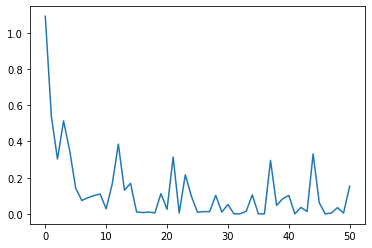

In [59]:
plt.plot(range(len(ll_c)), ll_c)


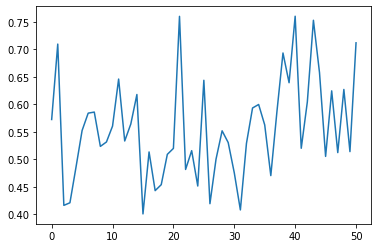

In [60]:
plt.plot(range(len(ll_d)), ll_d)


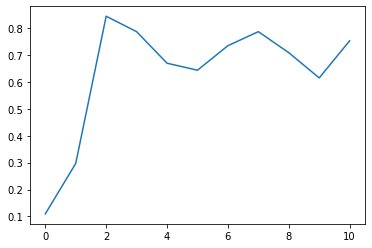

In [61]:
plt.plot(range(len(acc_lst)), acc_lst)


### Rough Work

In [77]:
class CNNN(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=3, hidden_dims=512):
        super(CNNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, hidden_dims, 3, padding=1),
            nn.BatchNorm2d(hidden_dims),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 3),
        )
        
    def forward(self, x):
        print(x.shape)
        h = self.conv(x).squeeze() # (N, hidden_dims)
        print(h.shape)
        h = self.classifier(h)
        return h
    


In [ ]:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (20): ReLU(inplace)
  (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (22): ReLU(inplace)
  (23): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (24): ReLU(inplace)
  (25): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (26): ReLU(inplace)
  (27): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (29): ReLU(inplace)
  (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (31): ReLU(inplace)
  (32): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (33): ReLU(inplace)
  (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (35): ReLU(inplace)
  (36): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [95]:
class SNNN(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=3, hidden_dims=512):
        super(SNNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 3),
        )
        
    def forward(self, x):
        #print(x.shape)
        h = self.conv(x).squeeze() # (N, hidden_dims)
        #print(h.shape)
        h = self.classifier(h)
        #print(h.shape)
        return h
    


In [44]:

resnet50 = models.resnet50(pretrained=True)
modules=list(resnet50.children())[:-1]
resnet50=nn.Sequential(*modules)

In [14]:
class SSNNN(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=3, hidden_dims=512):
        super(SSNNN, self).__init__()
        self.conv = resnet50
        
        self.classifier = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 3),
        )
        
    def forward(self, x):
        #print(x.shape)
        h = self.conv(x).squeeze() # (N, hidden_dims)
        #print(h.shape)
        h = self.classifier(h)
        #print(h.shape)
        return h
    


In [107]:
vgg = SSNNN()
vgg = vgg.to(device)
print(vgg)

SSNNN(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, 

In [45]:
resnet50 = models.resnet50(pretrained=True)
modules=list(resnet50.children())[:-1]
resnet50=nn.Sequential(*modules)

class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=3, hidden_dims=512):
        super(FeatureExtractor, self).__init__()
        self.conv = resnet50

    def forward(self, x):
        h = self.conv(x).squeeze() # (N, hidden_dims)
        return h

In [46]:
class Classifier(nn.Module):
    """
        Classifier
    """
    def __init__(self, input_size=2048, num_classes=3):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, h):
        c = self.layer(h)
        return c

In [49]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=2048, num_classes=2):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, h):
        y = self.layer(h)
        return y

In [50]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FF = FeatureExtractor().to(DEVICE)
CC = Classifier().to(DEVICE)

RuntimeError: CUDA error: device-side assert triggered

In [98]:
FF.load_state_dict(torch.load('F2.pt'))
FF.eval()

FeatureExtractor(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2

In [100]:
CC.load_state_dict(torch.load('C2.pt'))
CC.eval()

Classifier(
  (layer): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [27]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader1:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    temp1 = FF(images)
    outputs = CC(temp1)
    print(outputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the val images: %d %%' % (100 * correct / total))

RuntimeError: CUDA error: device-side assert triggered

In [221]:
#X = np.empty(shape=[0, 2048])
#Y = []
with torch.no_grad():
  for data in test_loader1:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    temp1 = vgg(images)
    outputs = temp1.cpu().numpy()
    #print(outputs.shape)
    lab = labels.cpu().numpy()
    #print(lab.shape)
    #X = np.concatenate((X, outputs), axis=0)
    #Y.append(lab)
    #print(Y)
type(Y)
    #print(outputs.data)
#tsne = TSNE(n_components=2).fit_transform(outputs)

numpy.ndarray

In [223]:
listOfStrings1 = ["o"] * 128
listOfStrings2 = ["v"] * 47
lst = listOfStrings1 + listOfStrings2

In [224]:
X = np.concatenate((outputs, output), axis=0)
Y = np.concatenate((lab, labs), axis=0)


In [222]:
outputs = outputs.reshape(128,2048)

In [225]:
import matplotlib.pyplot as plt

def mscatter(x,y, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    ax = ax or plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

No handles with labels found to put in legend.


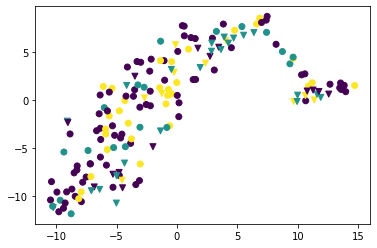

In [226]:
mscatter(tsne[:,0], tsne[:,1], m=lst, c=Y)
#plt.figure(figsize=(30,30))
ax.legend()
plt.show()

In [211]:
tsne = TSNE(n_components=2).fit_transform(X)

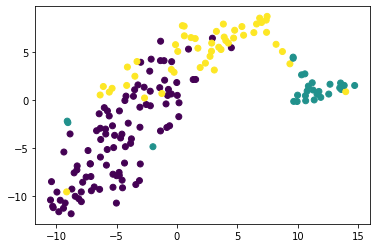

<Figure size 2160x2160 with 0 Axes>

In [213]:
plt.scatter(tsne[:,0], tsne[:,1], c=Y)
plt.figure(figsize=(30,30))
plt.show()


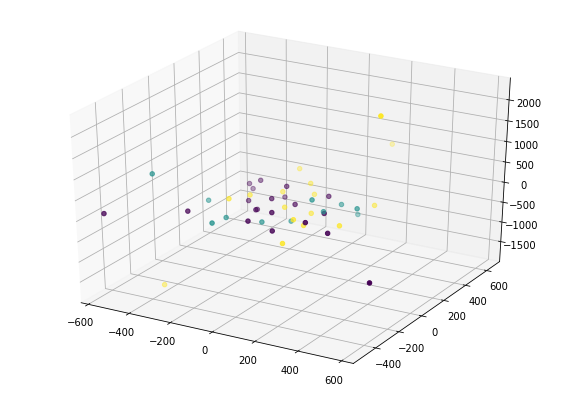

In [142]:
tsne = TSNE(n_components=3).fit_transform(outputs)
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(tsne[:,0], tsne[:,1], tsne[:,2], c=lab)
plt.show()


NameError: name 'colors_per_class' is not defined

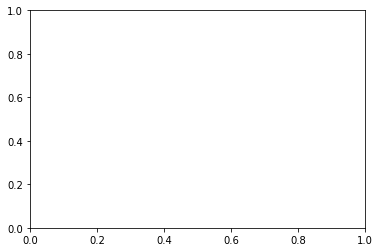

In [27]:

fig = plt.figure()
ax = fig.add_subplot(111)
for label in colors_per_class:
    indices = [i for i, l in enumerate(labels) if l == label]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    color = np.array(colors_per_class[label], dtype=np.float) / 255
    ax.scatter(current_tx, current_ty, c=color, label=label)
ax.legend(loc='best')
plt.show()


In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

ERROR: Could not find a version that satisfies the requirement tsne_torch
ERROR: No matching distribution found for tsne_torch
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
